#  **ICT303 - Assignment 1**

**Your name: <enter here your full name>**

**Student ID: <enter here your student ID>**

**Email: <enter here your email address>**






## **1. Description**

In this homework, you will build, train, test and compare the performance of multilayer perceptrons (MLP) and convolutional neural networks (CNNs) on a multi-class classification problem.

For this task, you will use the image dataset available [here](https://drive.google.com/file/d/1nWRm-Npq_QE0j_sHyVVxVEx2Rb0Lc1zU/view?usp=sharing). This dataset contains 8 categories of images distributed as shown in the following structure (in total 22 directories):




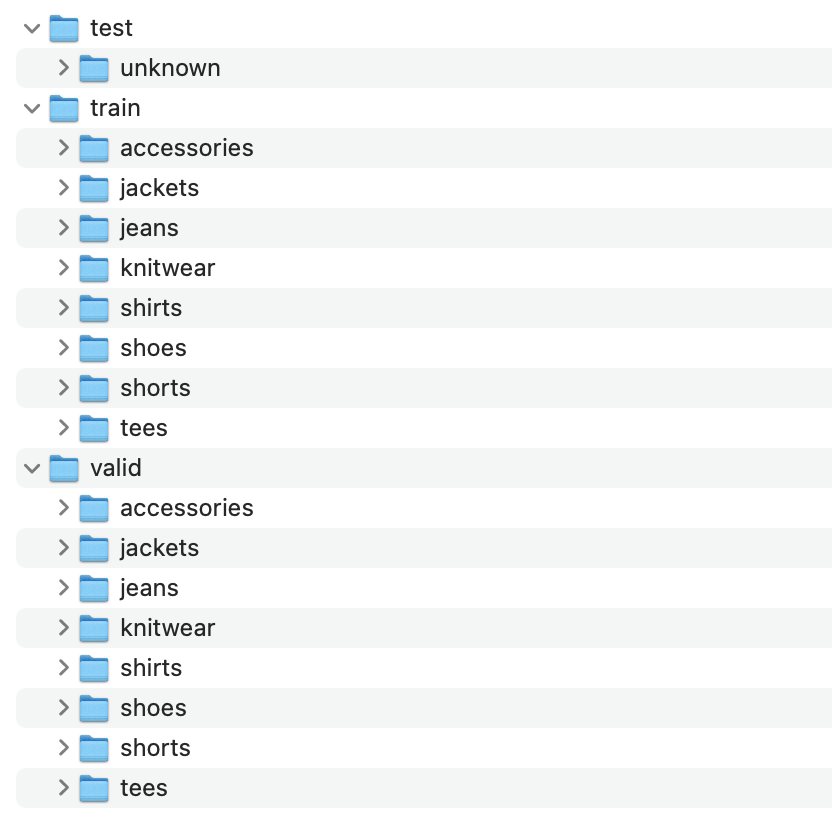


Your task is to:
1. Develop a multilayer perceptron model, train it and test it on the dataset. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
2. Implement VGG16, which a CNN architecture, train it and test it on the dataset. You must NOT use the pre-implemented VGG16 network in Pytorch. Instead, you have to implement all the layers and blocks yourself from scratch. You need to finetune the hyperparameters to select those that provide the best performance. **[40 Marks]**
3. Repeat step 2 above , but this time using the pretrained VGG16 network of PyTorch. **[20 Marks]**
4. For each of the tasks above, you need to finetune the hyper parameters to achieve the best performance possible.
5. Compare the performance of the three models.

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

For Perth campus students, enrolled in internal model, you will be required to demonstrate your work in class. External students may be called to demonstrate the work to their tutor.

## **2. What do you need to submit**

You must submit:
- your source code, in the form of python libraries (i.e., .py files)
- A colab notebook that
 - Describes your solution and design choices. It is highly recommended to visually show the architecture of the networks you developed. You must include a discussion on how the hyper parameters affect performance and how did you select the ones you are currently using.
 - Demonstrates the training and testing of the machine learning models you developed.
 - Plots the training and validation curves for each model. You are requried to use TensorBoard for this task.
 - Analyzes the performance, in terms of Confusion Matrix and Mean Average Precision (MAE), of the methods, and how the hyper parameters affect this performance.
 - Allows the visualization of some classification results.

Important notes
- The performance of the machine learning models can be significantly affected by (1) the amount of data on which they are traiined, and (2) preprocessing, such as normalization, of the data (I will talk about this in class).
- Your program must be structured following what we have seen in the labs. In other words, you must use Object-oriented Programming and have a class for the data, a class for the model, a class for the trainer. You are allowed to reuse code you create in the labs. Also, you are allowed (in fact sometimes you should) reuse code across different models. For example, you only need one class to manage the data, whether you are using MLPs or CNNs (VGG16 in our case).
- We have zero tolerance for plagaiarsism and misconduct (e.g., asking AI to do the work for you).


Some questions/clarifications to lecturer:


*   How to analyze performance? can we use sklearn python library?
*   We are not allowed to finetune the layer for our VGG16 model because it won't be VGG16 if I add/remove a layer.
* Are we encouraged to use a learning rate scheduler, early stopping, momentum update?
* For the pretrained VGG16, do we use torchvision.models.vgg16_bn or  torchvision.models.vgg16 (w/o batch normalization)
* Do we have to show/keep previous hyperparameter tuning results?



## Load tensorboard

In [1]:
%load_ext tensorboard
print("tensorboard extension loaded")

tensorboard extension loaded


## Import Dependencies and Data

In [2]:
import os
import shutil
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torch.optim.lr_scheduler import StepLR
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder # The data set that we will use
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
print("Dependencies Loaded!")

2025-06-18 12:21:39.328254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750220499.341624  366702 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750220499.345765  366702 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750220499.357098  366702 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750220499.357107  366702 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750220499.357108  366702 computation_placer.cc:177] computation placer alr

Dependencies Loaded!


In [3]:
!git clone https://github.com/Aithusa712/GoogleColab.git

Cloning into 'GoogleColab'...
remote: Enumerating objects: 4092, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 4092 (delta 33), reused 33 (delta 2), pack-reused 3990 (from 2)
Receiving objects: 100% (4092/4092), 78.01 MiB | 12.78 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [4]:
# For Linux
%cd GoogleColab/Assignment\ 1/

/home/aithusa/GoogleColab/Assignment 1


In [5]:
# For Windows
%cd "GoogleColab/Assignment 1"

[Errno 2] No such file or directory: 'GoogleColab/Assignment 1'
/home/aithusa/GoogleColab/Assignment 1


In [6]:
%ls

 data/  'ICT303 - Assignment 1.ipynb'


In [7]:
torch.cuda.empty_cache()

## Models

### MLP class implementation based on MLP architecture
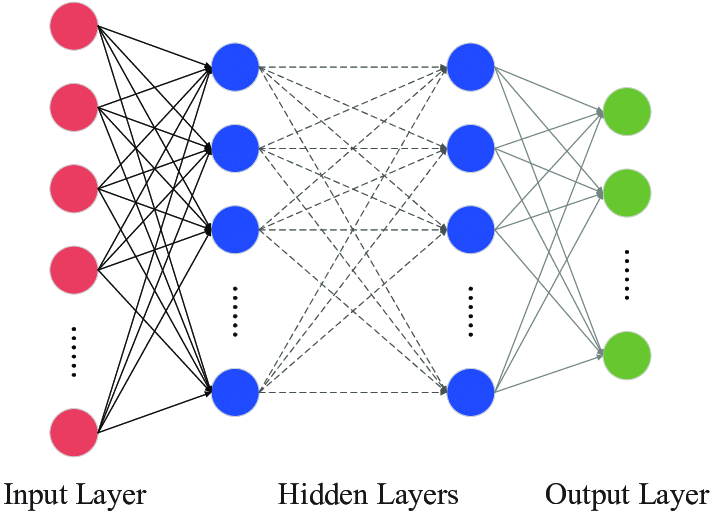

In [8]:
## The MLP class
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, inputSize=224 * 224 * 3, outputSize=8, lr=0.01, class_weights=None, dropout_rate = 0.3, optimizer_type = "adam"):
    super().__init__()

    self.lr = lr
    self.class_weights = class_weights
    self.optimizer_type = optimizer_type
    self.dropout_rate = dropout_rate

    self.layers = nn.Sequential(
        nn.Flatten(),
        # Input and First hidden Layer
        nn.Linear(inputSize, 512),
        nn.ReLU(),
        nn.Dropout(self.dropout_rate),
        # Second hidden Layer
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(self.dropout_rate),
        # Output Layer
        nn.Linear(128, outputSize),
    )


  ## The forward step
  def forward(self, X):
    return self.layers(X)

  def loss(self, y_hat, y):
    fn = nn.CrossEntropyLoss(weight=self.class_weights)
    return fn(y_hat, y)

  ## The optimization algorithm
  def configure_optimizers(self):
    if(self.optimizer_type=="adam"):
      return optim.Adam(self.parameters(), lr=self.lr)
    elif(self.optimizer_type=="sgd"):
      return optim.SGD(self.parameters(), lr=self.lr)
    else:
      return optim.Adam(self.parameters(), lr=self.lr)


### myVGG16 class implementation based on VGG16 Architecture
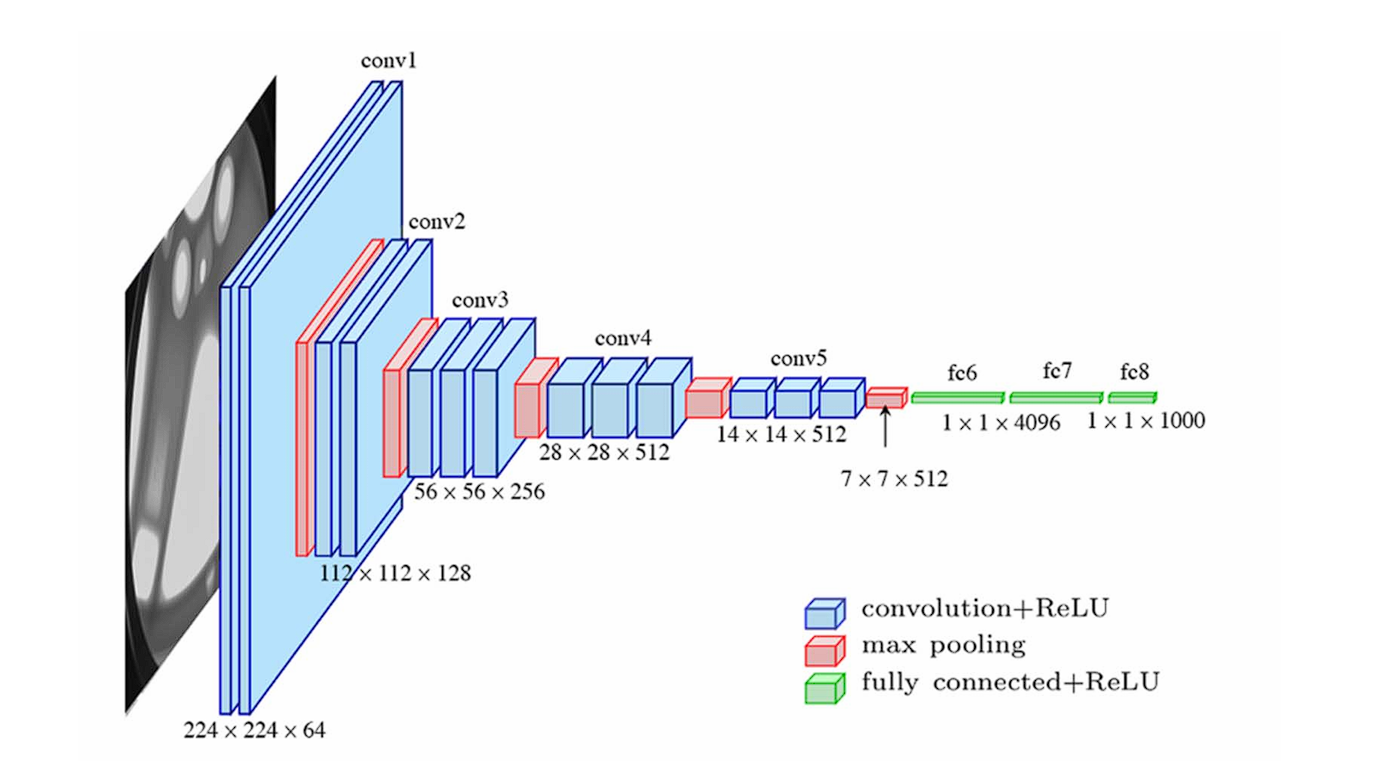

In [9]:
class myVGG16(nn.Module):
    def __init__(self, outputSize=8, lr=1e-4, class_weights=None, dropout_rate=0.3, optimizer_type="adam"):
        super().__init__()

        self.lr = lr
        #self._init_weights()
        self.class_weights = class_weights
        self.optimizer_type = optimizer_type
        #self.weight_decay=weight_decay
        self.dropout_rate = dropout_rate

        # VGG-16 convolution blocks
        self.conv_layer = nn.Sequential(
            #conv1
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),        # Convolution + ReLU
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),       # Convolution + ReLU
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            #conv2
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),      # Convolution + ReLU
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            #conv3
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            #conv4
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

            # conv5
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),     # Convolution + ReLU
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),                                           # Max Pooling

        )

        # For 224x224 input

        self.fc_layer = nn.Sequential(
          # fc6
          nn.Linear(512 * 7 * 7, 4096),
          nn.BatchNorm1d(4096),
          nn.ReLU(inplace=True),
          nn.Dropout(self.dropout_rate),
          # fc7
          nn.Linear(4096, 4096),
          nn.BatchNorm1d(4096),
          nn.ReLU(inplace=True),
          nn.Dropout(self.dropout_rate),
          # fc8
          nn.Linear(4096, outputSize)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

    def loss(self, y_hat, y):
       return nn.CrossEntropyLoss(weight=self.class_weights)(y_hat, y)

    def configure_optimizers(self):
      if(self.optimizer_type=="adam"):
        return optim.Adam(self.parameters(), lr=self.lr)
      elif(self.optimizer_type=="sgd"):
        return optim.SGD(self.parameters(), lr=self.lr)
      else:
        return optim.Adam(self.parameters(), lr=self.lr)

'''
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
'''

'\n    def _init_weights(self):\n        for m in self.modules():\n            if isinstance(m, nn.Conv2d):\n                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")\n                if m.bias is not None: nn.init.zeros_(m.bias)\n            elif isinstance(m, nn.Linear):\n                nn.init.normal_(m.weight, 0, 0.01)\n                nn.init.zeros_(m.bias)\n'

### Pytorch's Pretrained VGG16
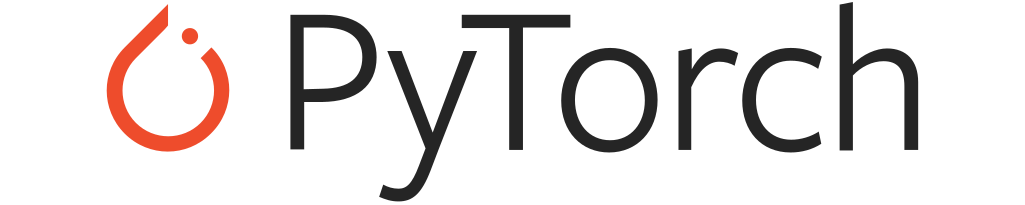

In [10]:
class PretrainedVGG16(nn.Module):
    def __init__(self, outputSize=8, lr=1e-4, class_weights=None, dropout_rate=0.3, optimizer_type="adam", weight_decay=1e-4):
        super().__init__()

        self.lr = lr
        self.class_weights = class_weights
        self.optimizer_type = optimizer_type
        self.weight_decay=weight_decay
        self.dropout_rate = dropout_rate

        # Load pretrained VGG16 with batch normalization
        base_model = vgg16_bn(weights=VGG16_BN_Weights.DEFAULT) #change to non BN variant

        # Freeze feature extractor if you want to fine-tune only classifier
        for param in base_model.features.parameters():
            param.requires_grad = False

        # Replace classifier with custom one
        base_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, outputSize)
        )

        self.model = base_model

    def forward(self, x):
        return self.model(x)

    def loss(self, y_hat, y):
        return nn.CrossEntropyLoss(weight=self.class_weights)(y_hat, y)

    def configure_optimizers(self):
        if self.optimizer_type == "adam":
            return optim.Adam(self.model.classifier.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        elif self.optimizer_type == "sgd":
            return optim.SGD(self.model.classifier.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        else:
            return optim.Adam(self.model.classifier.parameters(), lr=self.lr,weight_decay=self.weight_decay)


## Training Class

In [11]:
class Trainer:

  def __init__(self, tb, n_epochs = 3):
    self.max_epochs = n_epochs
    self.writer = tb  # the tensorboard instance
    return

  def fit(self, model, data, validation_data):
    self.data = data
    self.validation_data = validation_data

    # configure the optimizer
    self.optimizer = model.configure_optimizers()
    #self.scheduler = StepLR(self.optimizer, step_size=5, gamma=0.1)
    self.model     = model

    for epoch in range(self.max_epochs):
      print(f"\nEpoch {epoch + 1}/{self.max_epochs}")
      self.fit_epoch()
      self.validate_epoch()
      #self.scheduler.step()
      # Logging the average training loss so that it can be visualized in the tensorboard
      self.writer.add_scalar("Training Loss", self.avg_training_loss, epoch)
      self.writer.add_scalar("Validation Loss", self.avg_val_loss, epoch)

    print("Training process has finished")

  def fit_epoch(self):

    self.model.train()
    current_loss = 0.0
    self.avg_training_loss = 0.0

    # iterate over the DataLoader for training data
    for i, data in enumerate(tqdm(self.data, desc="Training")):
      # Get input
      inputs, target = data
      inputs, target = inputs.to(device), target.to(device) # use GPU


      # Clear gradient buffers because we don't want any gradient from previous
      # epoch to carry forward, dont want to cummulate gradients
      self.optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t to the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimizer.step()

      # Let's print some statistics (average of the training loss over minibatches of 500 data items)
      current_loss += loss.item()

      # Adding training loss
      self.avg_training_loss += loss.item()

      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

    # The average training loss
    self.avg_training_loss = self.avg_training_loss / i # to get the average
    print(f"Training Loss (avg): {self.avg_training_loss:.4f}")

  def validate_epoch(self):

    self.model.eval()
    total_loss = 0.0
    self.avg_val_loss = 0.0

    with torch.no_grad():
      # iterate over the DataLoader for training data
      for i, data in enumerate(self.validation_data):
        # Get input
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device) # use GPU

        # get output from the model, given the inputs
        outputs = self.model(inputs)

        # get loss for the predicted output
        loss = self.model.loss(outputs, target)

        total_loss += loss.item()

      # The average training loss
      self.avg_val_loss = total_loss / (i + 1) # to get the   average
      print(f"Validation Loss (avg): {self.avg_val_loss:.4f}")

## Data Loader Class

In [12]:
class myDataLoader:
    def __init__(self, train_dir="data/train", val_dir="data/valid", image_size=(224, 224)):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))
        ])

    def get_data(self):
        # Load datasets with ImageFolder
        train_dataset = ImageFolder(root=self.train_dir, transform=self.transform)
        val_dataset = ImageFolder(root=self.val_dir, transform=self.transform)

        # Extract and save training data
        train_images, train_labels = zip(*[(img, label) for img, label in train_dataset])
        train_images = torch.stack(train_images)
        train_labels = torch.tensor(train_labels)
        torch.save((train_images, train_labels), "train_tensor.pt")
        print("Training data saved as train_tensor.pt")

        # Extract and save validation data
        val_images, val_labels = zip(*[(img, label) for img, label in val_dataset])
        val_images = torch.stack(val_images)
        val_labels = torch.tensor(val_labels)
        torch.save((val_images, val_labels), "val_tensor.pt")
        print("Validation data saved as valid_tensor.pt")

        # Save class names
        with open("classes.txt", "w") as f:
            for class_name in train_dataset.classes:
                f.write(f"{class_name}\n")

    def load_data(self):
        train_images, train_labels = torch.load("train_tensor.pt")
        val_images, val_labels = torch.load("val_tensor.pt")
        with open("classes.txt", "r") as f:
            class_names = [line.strip() for line in f]
        return train_images, train_labels, val_images, val_labels, class_names

    def get_class_weights(self, labels, num_classes, device):
        label_counts = Counter(labels.tolist())
        class_weights = [(1 / label_counts[i]) ** 0.5 for i in range(num_classes)]
        return torch.tensor(class_weights, dtype=torch.float).to(device)

## Main Program

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Prepare / Load Data
print("Preparing and Loading Data....")
data_loader = myDataLoader()
data_loader.get_data()
train_images, train_labels, val_images, val_labels, class_names = data_loader.load_data()
print("Finished loading!")



# Compute class weights
num_classes = len(class_names)
class_weights = data_loader.get_class_weights(train_labels, num_classes, device)



Using device: cuda
Preparing and Loading Data....
Training data saved as train_tensor.pt
Validation data saved as valid_tensor.pt
Finished loading!


## Tune Hyperparameters

In [14]:
batch_size = 64 #32

### MLP

In [15]:
mlp_n_epochs = 13
mlp_lr = 5e-4 #5e-3 #5e-4 #5e-5

### myVGG16

In [16]:
myVGG16_n_epochs = 15
myVGG16_lr = 1e-5 #5e-4 #5e-3 #5e-4 #5e-5

### pretrained_VGG16

In [17]:
pretrained_VGG16_n_epochs = 15
pretrained_VGG16_lr = 1e-5 #1e-4 #5e-3 #5e-4 #5e-5 #1e-3

## Create Datasets and DataLoaders

In [18]:
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=12, pin_memory=True)

## Training

### Train MLP Model

In [19]:
print(f"Learning Rate: {mlp_lr}")
print(f"Max Epoch: {mlp_n_epochs}")
print(f"Batch Size: {batch_size}")

# Initialize Tensorboard Instance
if os.path.exists('runs/mlp'):
  shutil.rmtree('runs/mlp')
mlp_writer = SummaryWriter('runs/mlp')
# Initialize Model
mlp_model = MLP(outputSize=num_classes, lr=mlp_lr, class_weights=class_weights,).to(device)
# Train MLP model
mlp_trainer = Trainer(mlp_writer, mlp_n_epochs)
mlp_trainer.fit(mlp_model, train_loader, val_loader)

Learning Rate: 0.0005
Max Epoch: 13
Batch Size: 64

Epoch 1/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:02<00:00, 20.10it/s]

Training Loss (avg): 3.1840


Validation Loss (avg): 0.9760

Epoch 2/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.38it/s]

Training Loss (avg): 1.1008


Validation Loss (avg): 0.7756

Epoch 3/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.84it/s]

Training Loss (avg): 0.9492


Validation Loss (avg): 0.7297

Epoch 4/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.11it/s]

Training Loss (avg): 0.8518


Validation Loss (avg): 0.6698

Epoch 5/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.23it/s]

Training Loss (avg): 0.8036


Validation Loss (avg): 0.7588

Epoch 6/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.18it/s]

Training Loss (avg): 0.7855


Validation Loss (avg): 0.6700

Epoch 7/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.42it/s]

Training Loss (avg): 0.7083


Validation Loss (avg): 0.7384

Epoch 8/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.44it/s]

Training Loss (avg): 0.6909


Validation Loss (avg): 0.6590

Epoch 9/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.78it/s]

Training Loss (avg): 0.6756


Validation Loss (avg): 0.6769

Epoch 10/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 31.84it/s]

Training Loss (avg): 0.6634


Validation Loss (avg): 0.6362

Epoch 11/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.68it/s]

Training Loss (avg): 0.6256


Validation Loss (avg): 0.6603

Epoch 12/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 31.79it/s]

Training Loss (avg): 0.6436


Validation Loss (avg): 0.6186

Epoch 13/13


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.44it/s]

Training Loss (avg): 0.6027


Validation Loss (avg): 0.6366
Training process has finished


### Train myVGG16 Model

In [20]:
print(f"Learning Rate: {myVGG16_lr}")
print(f"Max Epoch: {myVGG16_n_epochs}")
print(f"Batch Size: {batch_size}")

# Initialize Tensorboard Instance
if os.path.exists('runs/my_vgg16'):
  shutil.rmtree('runs/my_vgg16')
vgg16_writer = SummaryWriter('runs/my_vgg16')
# Initialize Model
myVGG16_model = myVGG16(outputSize=num_classes, lr=myVGG16_lr, class_weights=class_weights).to(device)
# Train myVGG16 Model
vgg16_trainer = Trainer(vgg16_writer, myVGG16_n_epochs)
vgg16_trainer.fit(myVGG16_model, train_loader, val_loader)
vgg16_writer.close()

Learning Rate: 1e-05
Max Epoch: 15
Batch Size: 64

Epoch 1/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.9659


Validation Loss (avg): 0.8903

Epoch 2/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]


Training Loss (avg): 0.4139
Validation Loss (avg): 0.3880

Epoch 3/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.2380


Validation Loss (avg): 0.3104

Epoch 4/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.1431


Validation Loss (avg): 0.2611

Epoch 5/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.15it/s]

Training Loss (avg): 0.0771


Validation Loss (avg): 0.2409

Epoch 6/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.15it/s]

Training Loss (avg): 0.0449


Validation Loss (avg): 0.2248

Epoch 7/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.0312


Validation Loss (avg): 0.2103

Epoch 8/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.0233


Validation Loss (avg): 0.2064

Epoch 9/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.0199


Validation Loss (avg): 0.1964

Epoch 10/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.15it/s]

Training Loss (avg): 0.0135


Validation Loss (avg): 0.1973

Epoch 11/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.0110


Validation Loss (avg): 0.1972

Epoch 12/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.0106


Validation Loss (avg): 0.2019

Epoch 13/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.0096


Validation Loss (avg): 0.2006

Epoch 14/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.16it/s]

Training Loss (avg): 0.0079


Validation Loss (avg): 0.1961

Epoch 15/15


Training: 100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:47<00:00,  1.15it/s]

Training Loss (avg): 0.0069


Validation Loss (avg): 0.1917
Training process has finished


### Train PretrainedVGG16 Model

In [21]:
print(f"Learning Rate: {pretrained_VGG16_lr}")
print(f"Max Epoch: {pretrained_VGG16_n_epochs}")
print(f"Batch Size: {batch_size}")

# Initialize Tensorboard Instance
if os.path.exists('runs/pretrained_VGG16'):
  shutil.rmtree('runs/pretrained_VGG16')
pretrainedVGG16_writer = SummaryWriter('runs/pretrained_vgg16')
# Initialize Model
pretrainedVGG16_model = PretrainedVGG16(outputSize=num_classes, lr=pretrained_VGG16_lr, class_weights=class_weights).to(device)
# Train myVGG16 Model
pretrainedVGG16_trainer = Trainer(pretrainedVGG16_writer, pretrained_VGG16_n_epochs)
pretrainedVGG16_trainer.fit(pretrainedVGG16_model, train_loader, val_loader)
pretrainedVGG16_writer.close()

Learning Rate: 1e-05
Max Epoch: 15
Batch Size: 64

Epoch 1/15


Training:  65%|████████████████████████████████████████████████████▎                           | 36/55 [00:10<00:05,  3.28it/s]


KeyboardInterrupt: 

### Performance and Testing

### Test Model Accuracy

In [22]:
def test_model_on_device(test_device, dataloader, model):
    model.to(test_device)
    model.eval()
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(test_device), labels.to(test_device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end = time.time()
    print(f"Accuracy: {100 * correct / total:.2f}% - Inference Time: {end - start:.2f}s")

In [23]:
# MLP implementation
print("MLP:")

if torch.cuda.is_available():
    test_model_on_device(device, val_loader, mlp_model)
else:
    test_model_on_device(device, val_loader, mlp_model)


MLP:
Accuracy: 80.10% - Inference Time: 0.47s


In [24]:
# Pretrained VGG16 implementation
print("my VGG16:")

if torch.cuda.is_available():
    test_model_on_device(device, val_loader, myVGG16_model)
else:
    test_model_on_device(device, val_loader, myVGG16_model)

my VGG16:
Accuracy: 92.93% - Inference Time: 1.85s


In [ ]:
# Pretrained VGG16 implementation
print("Pretrained VGG16:")

if torch.cuda.is_available():
    test_model_on_device(device, val_loader, pretrainedVGG16_model)
else:
    test_model_on_device(device, val_loader, pretrainedVGG16_model)

### Visualization of test using test dataset

In [25]:
def model_predictions(model, model_name, device, test_dir="data/test", class_file="classes.txt", num_samples=8):

    # Load class names
    with open(class_file, "r") as f:
        class_names = [line.strip() for line in f]

    # Image transform
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Load test dataset
    test_dataset = ImageFolder(root=test_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Move model to device and eval mode
    model.to(device)
    model.eval()

    # Collect test images
    test_images = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            test_images.extend(inputs)
            if len(test_images) >= num_samples:
                break

    # Stack and move to device
    inputs = torch.stack(test_images[:num_samples]).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # Plot predictions
    fig, axs = plt.subplots(1, num_samples, figsize=(2 * num_samples, 3))
    fig.suptitle(f"{model_name} Predictions", fontsize=14)

    for i in range(num_samples):
        img = inputs[i].cpu() * 0.5 + 0.5  # Unnormalize
        img_np = img.permute(1, 2, 0).numpy()

        pred_idx = predicted[i].item()
        label = class_names[pred_idx] if pred_idx < len(class_names) else "Invalid"

        ax = axs[i] if num_samples > 1 else axs
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f"{label}", fontsize=9, pad=6)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

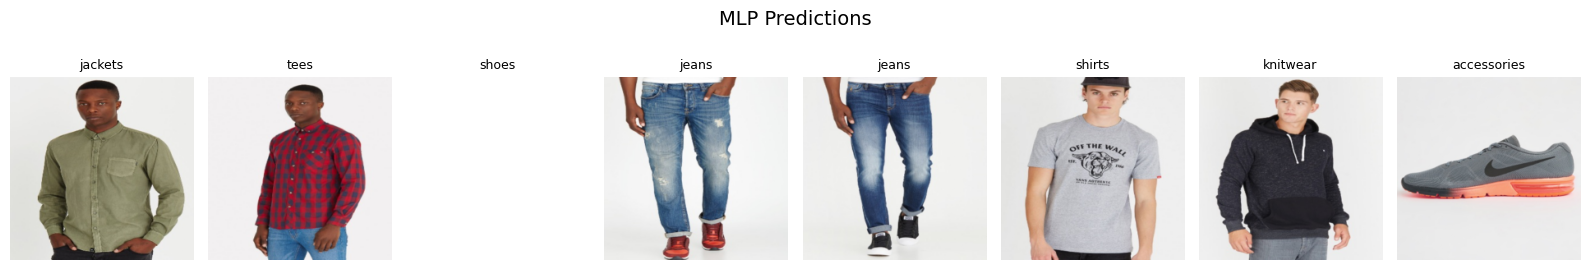

In [26]:
model_predictions(mlp_model, "MLP", device)

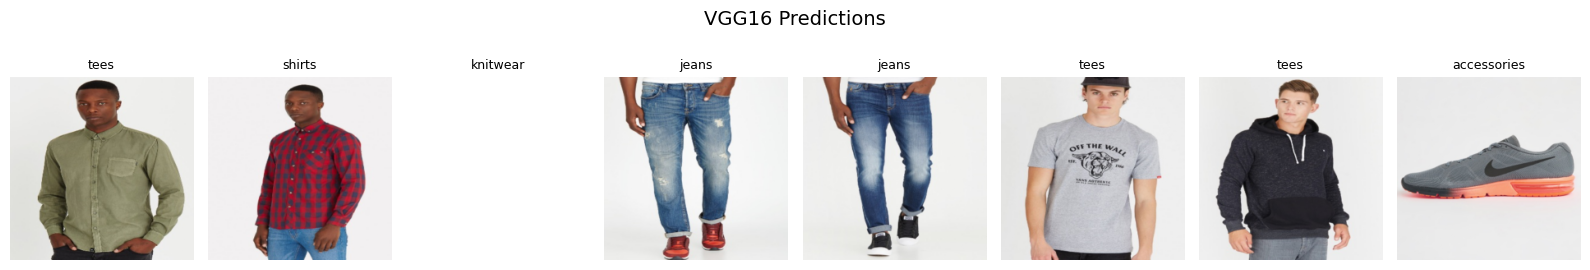

In [27]:
model_predictions(myVGG16_model, "VGG16", device)

In [ ]:
model_predictions(pretrainedVGG16_model, "Pretrained VGG16", device)

Save Models

In [ ]:
#torch.save(mlp_model.state_dict(), "mlp_model.pth")  # For MLP
#torch.save(myVGG16_model.state_dict(), "vgg16_model.pth")  # For VGG16
#torch.save(pretrainedVGG16_model.state_dict(), "pytorch_vgg16_model.pth")  # For VGG16

Tensorboard Output:

In [ ]:
!ls

In [ ]:
tensorboard --logdir runs